## Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import optimizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

Using TensorFlow backend.


## Load Dataset

In [2]:
covid_img_path = os.listdir('dataset/covid/')
normal_img_path = os.listdir('dataset/normal/')

In [3]:
covid_img_path = ['dataset/covid/' + x for x in covid_img_path]
normal_img_path = ['dataset/normal/' + x for x in normal_img_path]

In [4]:
data = []
labels = []

In [5]:
def read_image(image_path, label):  
 
    for img in image_path:
        #print("*")
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        data.append(image)
        labels.append(label)

In [6]:
read_image(covid_img_path, 1)
read_image(normal_img_path, 0)

### Normalize the data

In [7]:
data = np.array(data) / 255.0

### Convert labels into one-hot encoded vector

In [8]:
labels = to_categorical(labels, num_classes=None, dtype='float32')
labels = np.array(labels)

### Split the data intro train, test

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

### Initialize the training data augmentation object

In [10]:
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

### Load the VGG16 network, with include_top = False

In [11]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [12]:
for layer in baseModel.layers:
    layer.trainable = False

### Create to top architecture

In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

### Combine base model and head model

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [29]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Compile our model

In [ ]:
lr = 1e-3
epoch = 25
batch_size = 8

In [31]:
opt = optimizers.Adam(lr=lr, decay=lr / epoch)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

### Train the head of the network

In [47]:
history = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // batch_size,
    epochs=epoch)

Epoch 1/25
5/5 [==============================] - 15s 3s/step - loss: 3.8677 - accuracy: 0.4500 - val_loss: 2.0385 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 13s 3s/step - loss: 2.3067 - accuracy: 0.5750 - val_loss: 1.1189 - val_accuracy: 0.8000
Epoch 3/25
5/5 [==============================] - 14s 3s/step - loss: 0.9827 - accuracy: 0.7750 - val_loss: 0.5096 - val_accuracy: 0.8000
Epoch 4/25
5/5 [==============================] - 15s 3s/step - loss: 0.7846 - accuracy: 0.8500 - val_loss: 0.7950 - val_accuracy: 0.7000
Epoch 5/25
5/5 [==============================] - 15s 3s/step - loss: 0.9681 - accuracy: 0.7500 - val_loss: 0.6731 - val_accuracy: 0.8000
Epoch 6/25
5/5 [==============================] - 14s 3s/step - loss: 0.6990 - accuracy: 0.9000 - val_loss: 0.1338 - val_accuracy: 0.9000
Epoch 7/25
5/5 [==============================] - 14s 3s/step - loss: 0.5085 - accuracy: 0.8500 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 8/25
5/5 [==================

## Evaluation Of the Network

### Make predictions

In [80]:
pred = model.predict(X_test, batch_size=batch_size)
pred = np.argmax(pred, axis=1)

### Results

In [64]:
print(confusion_matrix(Y_test.argmax(axis=1), pred))
print(classification_report(Y_test.argmax(axis=1), pred,target_names=['normal', 'covid']))

[[4 1]
 [0 5]]
              precision    recall  f1-score   support

      normal       1.00      0.80      0.89         5
       covid       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



## Plot the training loss and accuracy

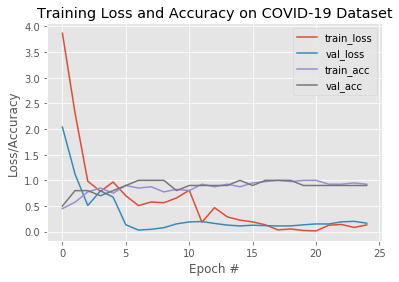

In [68]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epoch), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epoch), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig("plot")

### Save the model

In [15]:
model.save("models/model.h5")